In [1]:
# Avner Khan, Kiran Raja, Abhishek Khare, Joshua Deng
import matplotlib.pyplot as plt
from amb_sdk.sdk import DarwinSdk
from time import sleep
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
from sklearn.metrics import classification_report
import datetime

ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())


In [2]:
#Create a new user
status, msg = ds.auth_login_user('AVNERKHAN@UTEXAS.edu', 'xcGPvw7VMm')
if not status:
    print(msg)
print(status)

True


In [4]:
def elapsed_time(oc_date, oc_time, rep_date, rep_time):
    oc_date_split_arr = oc_date.split("/")
    oc_date_month = oc_date_split_arr[0]
    oc_date_day = oc_date_split_arr[1]
    oc_date_year = oc_date_split_arr[2]
    oc_hr = int(oc_time // 100)
    if (oc_hr > 23):
        oc_hr = 23
    elif (oc_hr < 0):
        oc_hr = 0
    oc_min = int(oc_time % 100)
    if (oc_min > 59):
        oc_min = 59
    elif (oc_min < 0):
        oc_min = 0
    oc_datetime = datetime.datetime(int(oc_date_year), int(oc_date_month), int(oc_date_day), oc_hr, oc_min)
    rep_date_split_arr = rep_date.split("/")
    rep_date_month = rep_date_split_arr[0]
    rep_date_day = rep_date_split_arr[1]
    rep_date_year = rep_date_split_arr[2]
    rep_hr = int(rep_time // 100)
    if (rep_hr > 23):
        rep_hr = 23
    elif (rep_hr < 0):
        rep_hr = 0
    rep_min = int(rep_time % 100)
    if (rep_min > 59):
        rep_min = 59
    elif (rep_min < 0):
        rep_min = 0
    rep_datetime = datetime.datetime(int(rep_date_year), int(rep_date_month), int(rep_date_day), rep_hr, rep_min)
    elapsed = rep_datetime - oc_datetime
    return elapsed.total_seconds() / 3600

#Load data
dataset = pd.read_csv("Crime_Reports_Fixed_Labels.csv")
print('Original Length:', len(dataset))
#Drop Unused Columns
dataset = dataset.drop(columns=['Location', 'Category Description', 'UCR Category', 'PRA', 'APD Sector', 'APD District', 'Council District', 'Zip Code', 'Address', 'Incident Number', 'Highest Offense Description', 'Occurred Date Time', 'Report Date Time', 'Clearance Date', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude'])
#Drop rows with missing data
dataset = dataset.dropna()
#Create Elapsed Time Field and add it to our data
elapsed = []
for index, row in dataset.iterrows():
    elapsed.append(elapsed_time(row['Occurred Date'], row['Occurred Time'], row['Report Date'], row['Report Time']))
elapsed_df = pd.DataFrame(data=elapsed)
dataset['Elapsed Time'] = elapsed_df
dataset = dataset.drop(columns=['Occurred Date', 'Occurred Time', 'Report Date', 'Report Time'])
#Print Cleaned Data and save it as csv
print('Cleaned Length:', len(dataset))
print(dataset.head())
dataset.to_csv("Crime_Reports_Clean.csv")

Original Length  2124418
Cleaned Length  779225
    Highest Offense Code Family Violence                 Location Type  \
3                   2716               N   DEPARTMENT / DISCOUNT STORE   
47                  2716               N              RESIDENCE / HOME   
65                   402               N               OTHER / UNKNOWN   
68                   402               N  STREETS / HWY / ROAD / ALLEY   
88                  1800               N  STREETS / HWY / ROAD / ALLEY   

    Census Tract Clearance Status  Zip Codes  Single Member Council Districts  \
3          18.13                C     3642.0                              4.0   
47         24.09                C     3259.0                              2.0   
65         24.09                N     3259.0                              2.0   
68         18.12                C     3641.0                              4.0   
88          9.02                C     2857.0                              3.0   

    BOUNDARIES_singl

In [5]:
#Split and Save Train and Test Data
dataset = pd.read_csv("Crime_Reports_Clean.csv")
dataset = dataset.drop(dataset.columns[0], axis=1)
dataset = dataset.sample(frac=1)
train_data = dataset.iloc[:int(len(dataset)*.8)]
test_data = dataset.iloc[int(len(dataset)*.8):]
print('Train Data:', len(train_data))
print(train_data.head())
print()
print('Test Data:', len(test_data))
print(test_data.head())
train_data.to_csv("Crime_Reports_Train.csv")
test_data.to_csv("Crime_Reports_Test.csv")

Train Data: 623380
        Highest Offense Code Family Violence          Location Type  \
707051                  3401               N       RESIDENCE / HOME   
113568                  3400               N       RESIDENCE / HOME   
716463                   902               Y       RESIDENCE / HOME   
464277                   600               N       RESIDENCE / HOME   
37516                    600               N  GROCERY / SUPERMARKET   

        Census Tract Clearance Status  Zip Codes  \
707051         18.20                N     3646.0   
113568         13.08                N     2859.0   
716463          3.07                N     2865.0   
464277         18.11                N     3641.0   
37516          23.04                C     3256.0   

        Single Member Council Districts  BOUNDARIES_single_member_districts  \
707051                              4.0                                 9.0   
113568                              3.0                                 3.0   
7164

In [6]:
#Upload Train Data
status, message = ds.delete_dataset("Crime_Reports_Train.csv")
print(status, message)
status, uploaded_dataset = ds.upload_dataset("Crime_Reports_Train.csv")
if not status:
    print(uploaded_dataset)

#Clean Train Data
target = "Clearance Status"
status, job_id = ds.clean_data("Crime_Reports_Train.csv", target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

False 404: NOT FOUND - {"message": "Dataset name not found"}

{'status': 'Requested', 'starttime': '2019-04-20T11:56:30.950908', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['64d3b6c2b2764cf5be6b50a32633b45f'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T11:56:30.950908', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['64d3b6c2b2764cf5be6b50a32633b45f'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T11:56:30.950908', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['64d3b6c2b2764cf5be6b50a32633b45f'], 'model_name': None, 'job_error': ''}
{'status':

In [7]:
#Creating Model
model = target + "_model" + ts
status, message = ds.delete_model(model)
print(status, message)
status, job_id = ds.create_model(dataset_names = "Crime_Reports_Train.csv", \
                                 model_name =  model, \
                                 max_train_time = '01:00')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    

False 400: BAD REQUEST - {"message": "Model does not exist"}

{'status': 'Requested', 'starttime': '2019-04-20T11:59:56.880633', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420114554', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T11:59:56.880633', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T11:59:56.880633', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 

{'status': 'Running', 'starttime': '2019-04-20T11:59:56.880633', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': 0.43185436725616455, 'generations': 1, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T11:59:56.880633', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': 0.43185436725616455, 'generations': 1, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T11:59:56.880633', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': 0.43185436725616455, 'generations': 1, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04

In [8]:
#Analyzing Models
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T13:08:24.756755', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.42816871404647827, 'generations': 6, 'dataset_names': None, 'artifact_names': ['2d2f3b820e954002bc2c25820656dbf1'], 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T13:08:24.756755', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.42816871404647827, 'generations': 6, 'dataset_names': None, 'artifact_names': ['2d2f3b820e954002bc2c25820656dbf1'], 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T13:08:24.756755', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.42816871404647827, 'generations': 6, 'dataset_names': None, 'artifact_names': ['2d2f3b820e954002bc2c25820656dbf1'], 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status':

In [9]:
print(feature_importance)

Highest Offense Code                                        4.006581e-01
Unnamed: 0                                                  1.341023e-01
Location Type = STREETS / HWY / ROAD / ALLEY                1.168162e-01
Location Type = RESIDENCE / HOME                            8.675619e-02
Family Violence = Y                                         7.704243e-02
Elapsed Time                                                2.677604e-02
Census Tract                                                2.543925e-02
Zoning Review Cases_data                                    2.543462e-02
Location Type = DEPARTMENT / DISCOUNT STORE                 1.927089e-02
Location Type = GROCERY / SUPERMARKET                       1.752925e-02
Zip Codes                                                   1.524369e-02
Location Type = COMMERCIAL / OFFICE BUILDING                7.941634e-03
Location Type = PARKING LOTS / GARAGE                       7.873082e-03
Location Type = OTHER / UNKNOWN                    

In [10]:
#Upload Test Data
status, message = ds.delete_dataset("Crime_Reports_Test.csv")
print(status, message)
status, dataset = ds.upload_dataset("Crime_Reports_Test.csv")
if not status:
    print(dataset)
    
#Clean Test Data
status, job_id = ds.clean_data("Crime_Reports_Test.csv", target = target, model_name = model)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

False 404: NOT FOUND - {"message": "Dataset name not found"}

{'status': 'Requested', 'starttime': '2019-04-20T13:10:39.958568', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['179628b8f9614bb2911d4db154bf8bd5'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T13:10:39.958568', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['179628b8f9614bb2911d4db154bf8bd5'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T13:10:39.958568', 'endtime': '2019-04-20T13:11:03.145297', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['179628b8f9614bb2911d4db154bf8bd5'], 'model_name': None, 'jo

{'status': 'Running', 'starttime': '2019-04-20T13:13:18.206631', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.42816871404647827, 'generations': 6, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['ab042fe7aabd41c8973ecba33e3c2acc'], 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T13:13:18.206631', 'endtime': '2019-04-20T13:13:25.532064', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.42816871404647827, 'generations': 6, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['ab042fe7aabd41c8973ecba33e3c2acc'], 'model_name': 'Clearance Status_model20190420114554', 'job_error': ''}
              precision    recall  f1-score   support

           C       0.87      0.83      0.85     54553
           N       0.91      0.94      0.92    101292

   micro avg       0.90      0.90      0.90    155845
   macro avg       0.89      0.88      0.89    155845
weigh

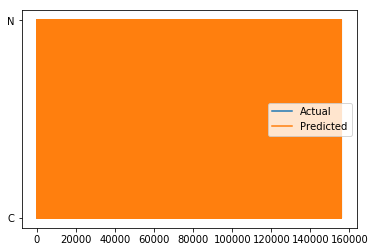

In [11]:
#Run Model on Test Data
status, artifact = ds.run_model("Crime_Reports_Test.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv("Crime_Reports_Test.csv")
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [12]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBClassifier', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.268008771835894, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 141, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9920498303538875}}
